In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [102]:
########################################
# DataFrame Setup Function
########################################

def setup_dataframes(dataset_name, infer_mode, features, attribute=None):
    if attribute:
        log_path = dataset_name + '/monitoring_' + attribute + '_quality_log.csv'
        train = 'train_batch'
        infer = 'infer_batch'
    else:
        log_path = dataset_name + '/monitoring_quality_log.csv'
        train = 'skip_training_starting_batch'
        infer = 'batch'

    df_full = pd.read_csv(log_path, sep=';')
#     df_full = df_full[['infer_mode', 'features', 'dk_cells', train,
#                        infer, 'precision', 'recall', 'f1', ]]
    df_full.drop_duplicates(keep='last', inplace=True)

    df = df_full.loc[(df_full['infer_mode'] == infer_mode) & (df_full['features'] == features)]

    df_list = []
    for skip_training_starting_batch in df[train].unique().tolist():
        tmp_df = df.loc[df[train] == skip_training_starting_batch]
        tmp_df = tmp_df.astype({'dk_cells': 'int32', infer: 'int32', 'total_errors': 'int32',
                                'correct_repairs': 'int32', 'total_repairs_grdt': 'int32',
                                'precision': 'float64', 'recall': 'float64', 'f1': 'float64'})

        df_list.append(tmp_df)

    return df_list

In [179]:
########################################
# Chart Plotting Function
########################################

def plot_charts(df_list, attribute=None):
    if attribute:
        train = 'train_batch'
        infer = 'infer_batch'
    else:
        train = 'skip_training_starting_batch'
        infer = 'batch'

    count = 0

    chart_rows = 33
    chart_columns = 3
    fig, axes = plt.subplots(chart_rows, chart_columns, sharex=True, sharey=True,
                             figsize=(chart_columns * 7, chart_rows * 5))

    for i in range(chart_rows):
        for j in range(chart_columns):
            current_df = df_list[count]
            count += 1
            
            current_df.loc[current_df['dk_cells'] == 0, ['precision', 'recall', 'f1']] = 1

            axes[i, j].plot(infer, 'precision',
                            data=current_df, marker='', color=palette(1), label='precision', linewidth=3)
            axes[i, j].plot(infer, 'recall',
                            data=current_df, marker='', color=palette(2), label='recall', linewidth=3)
            axes[i, j].plot(infer, 'f1',
                            data=current_df, marker='', color=palette(3), label='f1', linewidth=3)
            axes[i, j].legend(loc="lower right")

            skip_training_starting_batch = current_df[train].iloc[0]
            title_str = 'Training up to batch {}'.format(skip_training_starting_batch)
            axes[i, j].set(title=title_str)

            if j == 0:
                axes[i, j].set(ylabel='Percentage')
            if i == chart_rows - 1:
                axes[i, j].set(xlabel='Batch')

    fig.tight_layout()

In [131]:
def plot_charts_acc(df_list, attribute=None):
    if attribute:
        train = 'train_batch'
        infer = 'infer_batch'
    else:
        train = 'skip_training_starting_batch'
        infer = 'batch'

    count = 0
    prev_values = {'total_errors':  0, 'correct_repairs': 0, 'total_repairs_grdt': 0}

    chart_rows = 5  # 33
    chart_columns = 3
    fig, axes = plt.subplots(chart_rows, chart_columns, sharex=True, sharey=True,
                             figsize=(chart_columns * 7, chart_rows * 5))

    for i in range(chart_rows):
        for j in range(chart_columns):
            current_df = df_list[count]
            count += 1

            for metric in prev_values.keys():
                # Sets the first entry to the accumulated value up to it.
                current_df.loc[current_df.index[0], metric] = current_df.loc[current_df.index[0], metric] + prev_values[metric]
                prev_values[metric] = current_df.loc[current_df.index[0], metric]
                # Gets the accumulated values.
                current_df[metric] = current_df[metric].cumsum()

            current_df['acc_precision'] = current_df['correct_repairs'] / current_df['total_repairs_grdt']
            current_df['acc_recall'] = current_df['correct_repairs'] / current_df['total_errors']
            current_df['acc_f1'] = (2 * current_df['acc_precision'] * current_df['acc_recall']) \
                / (current_df['acc_precision'] + current_df['acc_recall'])
            
            axes[i, j].plot(infer, 'acc_precision',
                            data=current_df, marker='', color=palette(1), label='Precision', linewidth=3)
            axes[i, j].plot(infer, 'acc_recall',
                            data=current_df, marker='', color=palette(2), label='Recall', linewidth=3)
            axes[i, j].plot(infer, 'acc_f1',
                            data=current_df, marker='', color=palette(3), label='F1', linewidth=3)
            axes[i, j].legend(loc="lower right")

            skip_training_starting_batch = current_df[train].iloc[0]
            title_str = 'Training up to batch {}'.format(skip_training_starting_batch)
            axes[i, j].set(title=title_str)

            if j == 0:
                axes[i, j].set(ylabel='Percentage')
            if i == chart_rows - 1:
                axes[i, j].set(xlabel='Batch')

    fig.tight_layout()

In [132]:
########################################
# Charts: Setup
########################################

plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab10')

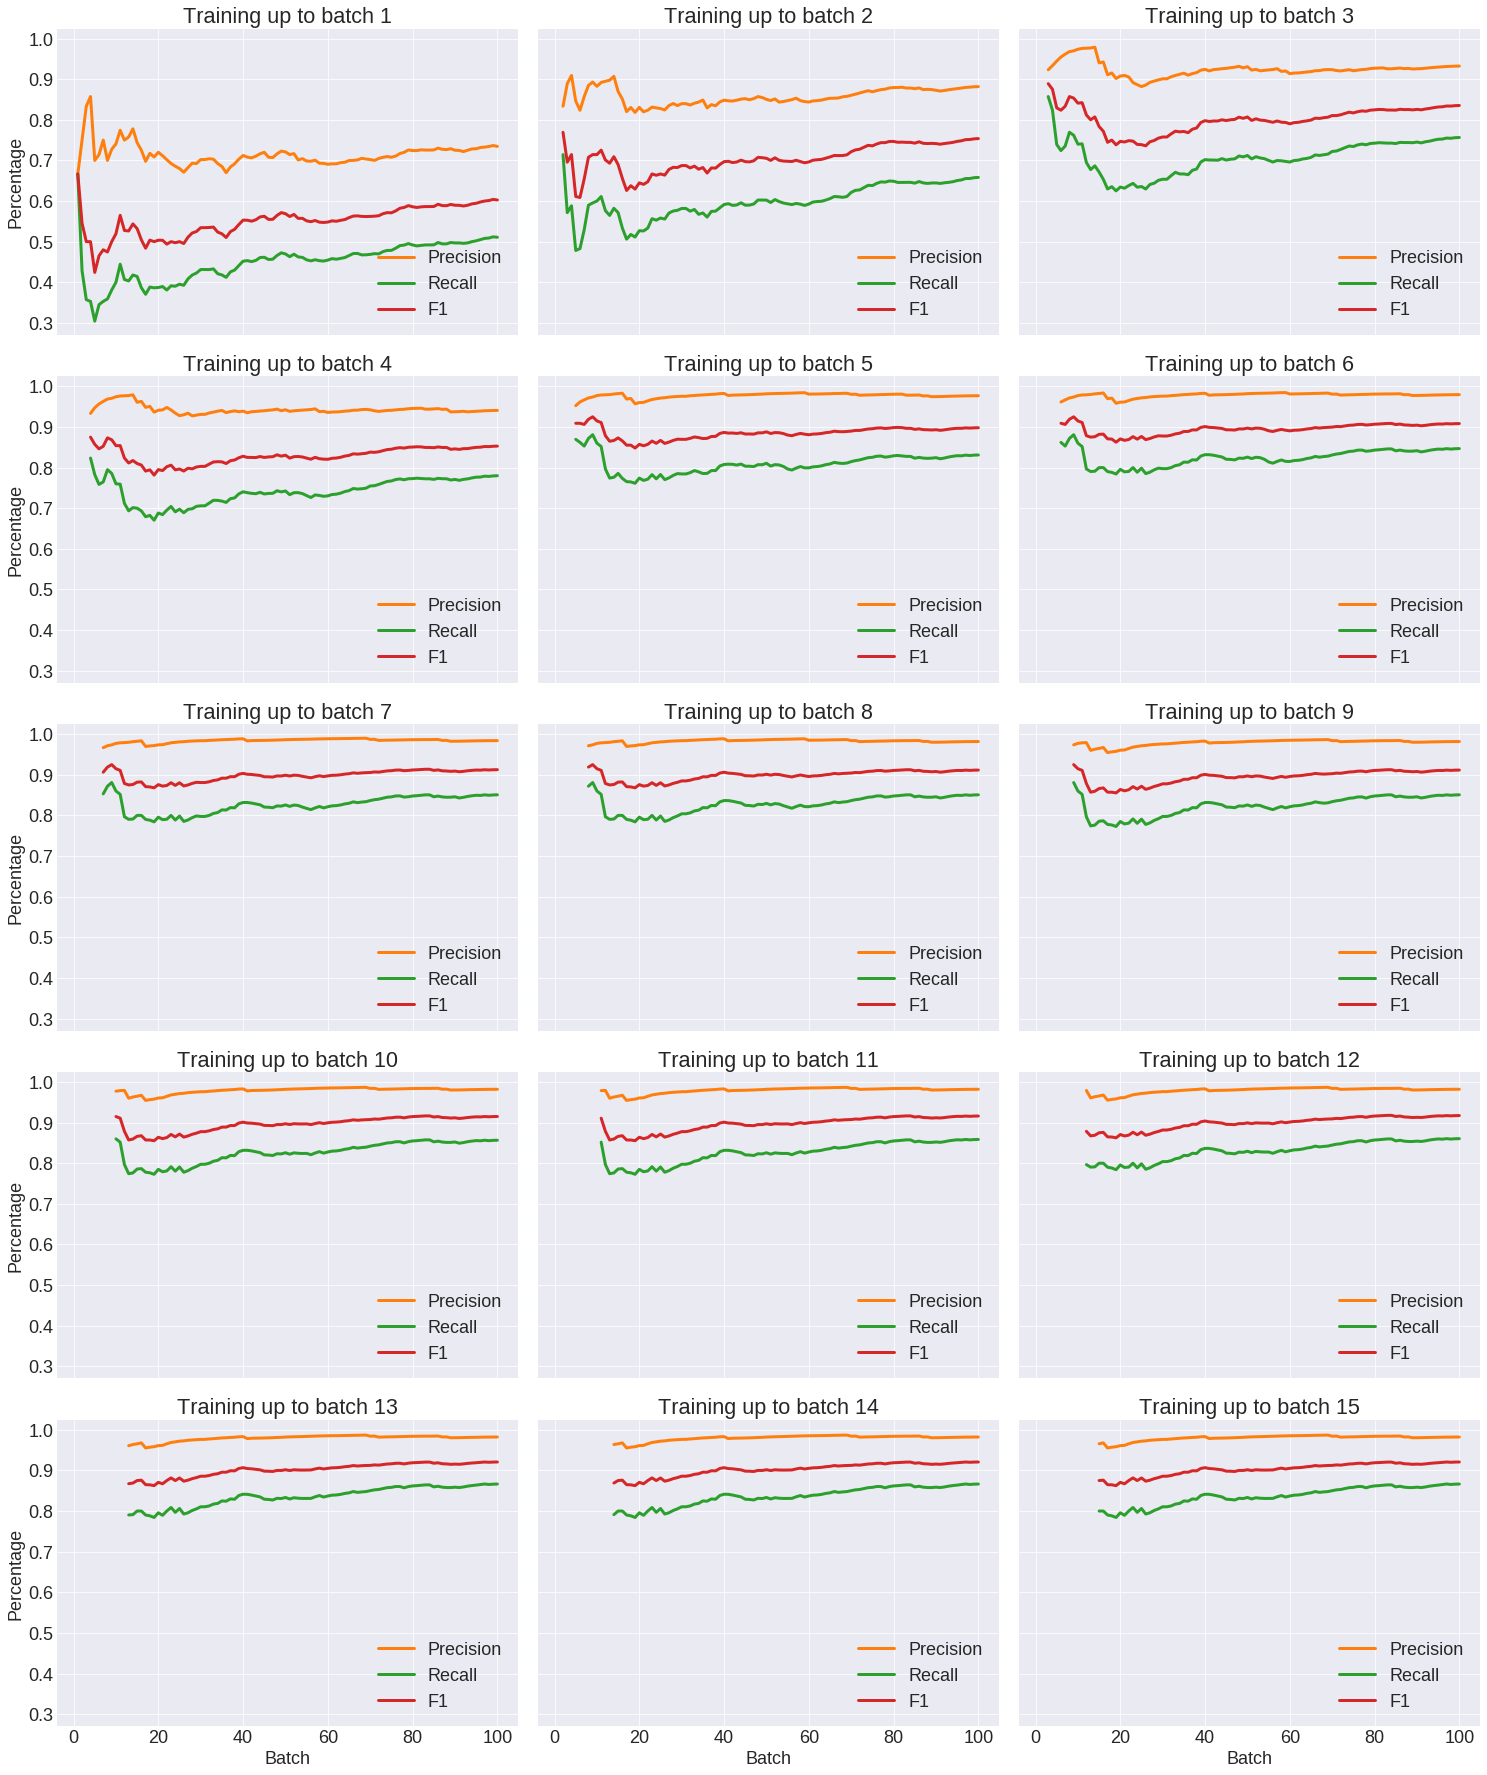

In [184]:
########################################
# Charts: Analysis
########################################

# An attribute name or None.
attribute = None

# 1st argument: 'dk' or 'all'.
# 2nd argument: 'incremental' or 'global'.

plot_charts_acc(setup_dataframes('hospital', 'dk', 'incremental', attribute), attribute)

In [162]:
dataset_name = 'hospital'
df = pd.read_csv(dataset_name + '/monitoring_quality_log.csv', sep=';')

df

,infer_mode,features,train_using_all_batches,skip_training_starting_batch,batch,dk_cells,training_cells,precision,recall,repairing_recall,f1,repairing_f1,detected_errors,total_errors,correct_repairs,total_repairs,total_repairs_grdt,repairs_on_correct_cells,repairs_on_incorrect_cells,rmse
0,dk,global,True,1,1,3,154,1.0,1.0,1.0,1.0,1.0,3,3,3,3,3,0,3,0
1,dk,global,True,1,2,4,154,1.0,0.75,0.75,0.8571428571428571,0.8571428571428571,4,4,3,3,3,0,3,0
2,dk,global,True,1,3,7,154,1.0,0.7142857142857143,0.7142857142857143,0.8333333333333333,0.8333333333333333,7,7,5,5,5,0,5,0
3,dk,global,True,1,4,3,154,0.6666666666666666,0.6666666666666666,0.6666666666666666,0.6666666666666666,0.6666666666666666,3,3,2,3,3,0,3,0
4,dk,global,True,1,5,6,154,0.8333333333333334,0.8333333333333334,0.8333333333333334,0.8333333333333334,0.8333333333333334,6,6,5,6,6,0,6,0
5,dk,global,True,1,6,6,154,1.0,0.8333333333333334,0.8333333333333334,0.9090909090909091,0.9090909090909091,6,6,5,5,5,0,5,0
6,dk,global,True,1,7,5,154,1.0,1.0,1.0,1.0,1.0,5,5,5,5,5,0,5,0
7,dk,global,True,1,8,5,154,1.0,1.0,1.0,1.0,1.0,5,5,5,5,5,0,5,0
8,dk,global,True,1,9,3,154,1.0,1.0,1.0,1.0,1.0,3,3,3,3,3,0,3,0
9,dk,global,True,1,10,7,154,0.7142857142857143,0.625,0.7142857142857143,0.6666666666666666,0.7142857142857143,7,8,5,7,7,0,7,0
